In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
df = pd.read_csv("mathe_dataset.csv", sep=";", encoding="ISO-8859-1")

In [3]:
df['Keywords'] = df['Keywords'].str.split(',')

In [4]:
df.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"[Stem and Leaf diagram, Relative frequency, Sa..."


# Regression Problem: Predicting Student Performance, i.e., average score of correct answers

- Given the inputs: `Student Country, Question Levels, Topics, Subtopics and Keywords`, the goal is to predict the average score of correct answers of a student.
- We utilise these Regression models to solve this problem:
    - Linear Regression
    - Random Forest
    - Gradient Boosting
    - XGBoost

### Pre-processing

- Aggregate the data on Student ID, to get all the aggregated values for a student considering the questions they've answered.
- The aggregation is performed as follows:
    - Student Country: Since this stays the same for a student, we only consider the first value.
    - Obtain the unique values, then perform One-hot-encoding using Multi-label Binarizer for these variables:
        - Question Level
        - Topic
        - Subtopic
    - Use Tf-Idf Vectorizer as used in Classification for the Keywords.
    - The target variable: Average Score should be created using the simple formula: Correct_Answers/Total_Answers

In [5]:
aggregated_df = df.groupby("Student ID").agg(
    Student_Country=("Student Country", "first"),  # Keep first occurrence
    Correct_Answers=("Type of Answer", "sum"),  # Sum of 1s = correct answers
    Total_Answers=("Type of Answer", "count"),  # Count of total attempts
    Average_Score=("Type of Answer", "mean"),  # Mean = correct/total
    Question_Levels=("Question Level", lambda x: x.unique()),
    Topics=("Topic", lambda x: x.unique()),
    Subtopics=("Subtopic", lambda x: x.unique()),
    Keywords=("Keywords", lambda x: list(set([kw for sublist in x for kw in sublist])))  # Flatten & deduplicate
).reset_index()

In [6]:
aggregated_df.head()

,Student ID,Student_Country,Correct_Answers,Total_Answers,Average_Score,Question_Levels,Topics,Subtopics,Keywords
0,26,Portugal,58,77,0.753247,[Basic],"[Linear Algebra, Differential Equations, Proba...","[Linear Systems, Differential Equations, Proba...","[Cartesian equations of a line, Sample space, ..."
1,28,Portugal,35,59,0.593220,[Basic],"[Statistics, Linear Algebra, Complex Numbers, ...","[Statistics, Linear Systems, Complex Numbers, ...","[Frequency, Cartesian equations of a line, Med..."
2,36,Portugal,18,35,0.514286,"[Basic, Advanced]","[Differentiation, Linear Algebra, Set Theory]","[Derivatives, Linear Systems, Linear Transform...","[Determinant computation, Matrix operations, V..."
3,37,Portugal,87,140,0.621429,"[Basic, Advanced]","[Differentiation, Optimization, Differential E...","[Derivatives, Partial Differentiation, Nonline...","[Stationary point, Modulus of a complex number..."
4,41,Portugal,34,59,0.576271,"[Basic, Advanced]","[Statistics, Fundamental Mathematics, Differen...","[Statistics, Algebraic expressions, Equations,...","[Frequency, Indeterminate forms, Polyhedrons, ..."


In [7]:
len(aggregated_df)

372

In [8]:
multi_label_cols = ['Topics', 'Subtopics', 'Question_Levels']
preproc_df = aggregated_df.copy()

for col in multi_label_cols:
    preproc_df[col] = preproc_df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(preproc_df[col])
    preproc_df = preproc_df.join(pd.DataFrame(encoded, columns=[f"{col}_{cls}".replace(" ", "_").replace(",", "_") for cls in mlb.classes_]))
    preproc_df.drop(columns=[col], inplace=True)

In [9]:
preproc_df.head()

,Student ID,Student_Country,Correct_Answers,Total_Answers,Average_Score,Keywords,Topics_Analytic_Geometry,Topics_Complex_Numbers,Topics_Differential_Equations,Topics_Differentiation,...,Subtopics_Matrices_and_Determinants,Subtopics_Nonlinear_Optimization,Subtopics_Numerical_Methods,Subtopics_Partial_Differentiation,Subtopics_Probability_,Subtopics_Set_Theory,Subtopics_Statistics,Subtopics_Vector_Spaces,Question_Levels_Advanced,Question_Levels_Basic
0,26,Portugal,58,77,0.753247,"[Cartesian equations of a line, Sample space, ...",1,0,1,1,...,0,0,0,1,1,1,0,0,0,1
1,28,Portugal,35,59,0.593220,"[Frequency, Cartesian equations of a line, Med...",1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,36,Portugal,18,35,0.514286,"[Determinant computation, Matrix operations, V...",0,0,0,1,...,1,0,0,0,0,1,0,1,1,1
3,37,Portugal,87,140,0.621429,"[Stationary point, Modulus of a complex number...",1,1,1,1,...,0,1,1,1,1,0,0,0,1,1
4,41,Portugal,34,59,0.576271,"[Frequency, Indeterminate forms, Polyhedrons, ...",1,1,1,0,...,0,0,0,0,0,0,1,0,1,1


In [10]:
vectorizer = TfidfVectorizer(max_features=100)
preproc_df['Keywords'] = preproc_df['Keywords'].apply(lambda x: ' '.join(x))
keywords_tfidf = vectorizer.fit_transform(preproc_df['Keywords']).toarray()

In [11]:
keywords_df = pd.DataFrame(keywords_tfidf, columns=[f"keyword_{i}" for i in range(keywords_tfidf.shape[1])])
preproc_df = preproc_df.drop(columns=['Keywords']).reset_index(drop=True)
preproc_df = pd.concat([preproc_df, keywords_df], axis=1)

In [12]:
preproc_df = pd.get_dummies(preproc_df, columns=['Student_Country'], drop_first=True)

In [13]:
preproc_df.head()

,Student ID,Correct_Answers,Total_Answers,Average_Score,Topics_Analytic_Geometry,Topics_Complex_Numbers,Topics_Differential_Equations,Topics_Differentiation,Topics_Fundamental_Mathematics,Topics_Graph_Theory,...,keyword_97,keyword_98,keyword_99,Student_Country_Italy,Student_Country_Lithuania,Student_Country_Portugal,Student_Country_Romania,Student_Country_Russian Federation,Student_Country_Slovenia,Student_Country_Spain
0,26,58,77,0.753247,1,0,1,1,0,0,...,0.112708,0.000000,0.000000,False,False,True,False,False,False,False
1,28,35,59,0.593220,1,1,0,0,0,0,...,0.100546,0.090503,0.091080,False,False,True,False,False,False,False
2,36,18,35,0.514286,0,0,0,1,0,0,...,0.101048,0.000000,0.000000,False,False,True,False,False,False,False
3,37,87,140,0.621429,1,1,1,1,1,0,...,0.000000,0.000000,0.071147,False,False,True,False,False,False,False
4,41,34,59,0.576271,1,1,1,0,1,1,...,0.000000,0.099218,0.099850,False,False,True,False,False,False,False


### Performing Train-Test Splits

- Get the X (feature values) and y (target class variable)
- Split X and y using the ratio of 80:20 and a random state of 42.

In [15]:
X = preproc_df.drop(["Student ID", "Average_Score"], axis=1)
y = preproc_df["Average_Score"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Declare the regressors to be used

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [18]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    rmse = mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
    r2 = r2_score(y_test, y_pred)  # R² Score
    
    results[name] = {"RMSE": rmse, "R² Score": r2}

In [19]:
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R² Score = {scores['R² Score']:.4f}")

Linear Regression: RMSE = 0.1736, R² Score = -1.4934
Random Forest: RMSE = 0.0083, R² Score = 0.8813
Gradient Boosting: RMSE = 0.0086, R² Score = 0.8766
XGBoost: RMSE = 0.0049, R² Score = 0.9292


### As we can observe, Linear Regression has a negative R-squared value. This indicates a Dimensionality problem. Therefore, we try to reduce the dimensionality of features using PCA.

In [20]:
pca = PCA(n_components=30)
X_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

# Evaluate performance
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression after PCA: RMSE = {rmse:.4f}, R² Score = {r2:.4f}")

Linear Regression after PCA: RMSE = 0.0572, R² Score = 0.1790


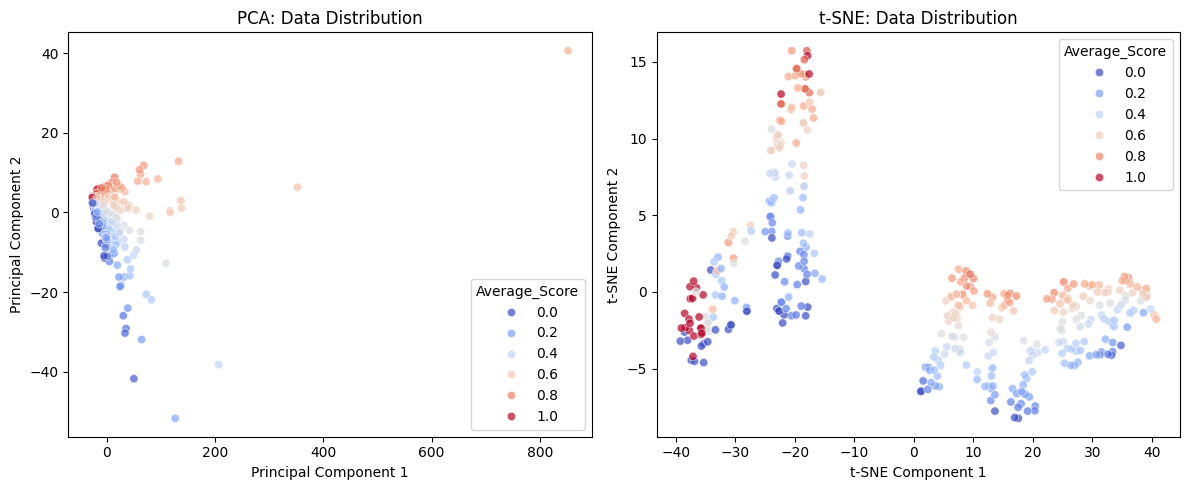

In [22]:
# Reduce to 2D using PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

# Reduce to 2D using t-SNE (captures complex structure)
X_tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("PCA: Data Distribution")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue=y, palette="coolwarm", alpha=0.7)
plt.title("t-SNE: Data Distribution")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()